# Physiology Lab - Fall 2019
# Oxygen Equilibrium of Hemocyanin Report

For this report, Dr. Beers only wants three graphs generated from the data obtained during lab. 

1. Plot % Oxygen Saturation (y-axis) as a funciton of oxygen partial pressure (x-axis). Determine the P<sub>50</sub> of the pigment under the experimental conditions.

In [2]:
hemodat = read.csv('OxygenEqHemo.csv')
hemodat$pH = as.factor(hemodat$pH)

In [3]:
hemodat$hill = log((hemodat$Percent.Oxy.Sat)*100/(100-(hemodat$Percent.Oxy.Sat*100)))
head(hemodat)

pH,Volume.O2.Added..mL.,Absorbance,Barometric.Pressure..Torr.,Vapor.Pressure..Torr.,Volume.of.Tonometer..mL.,PO2,Percent.Oxy.Sat,hill
<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
7.3,0,0.007,764.25,24.195,610,0.000000,NA,NA
7.3,5,0.017,764.25,24.195,610,6.066025,0.03717472,-3.2542430
7.3,15,0.027,764.25,24.195,610,18.198074,0.07434944,-2.5217206
7.3,35,0.070,764.25,24.195,610,42.462172,0.23420074,-1.1847414
7.3,55,0.153,764.25,24.195,610,66.726270,0.54275093,0.1714223
7.3,65,0.194,764.25,24.195,610,78.858320,0.69516729,0.8243894


In [4]:
hem_73 = hemodat[hemodat$pH == '7.3',]
hem_68 = hemodat[hemodat$pH == '6.8',]
hem_78 = hemodat[hemodat$pH == '7.8',]
hem_73

pH,Volume.O2.Added..mL.,Absorbance,Barometric.Pressure..Torr.,Vapor.Pressure..Torr.,Volume.of.Tonometer..mL.,PO2,Percent.Oxy.Sat,hill
<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
7.3,0,0.007,764.25,24.195,610,0.000000,NA,NA
7.3,5,0.017,764.25,24.195,610,6.066025,0.03717472,-3.2542430
7.3,15,0.027,764.25,24.195,610,18.198074,0.07434944,-2.5217206
7.3,35,0.070,764.25,24.195,610,42.462172,0.23420074,-1.1847414
7.3,55,0.153,764.25,24.195,610,66.726270,0.54275093,0.1714223
7.3,65,0.194,764.25,24.195,610,78.858320,0.69516729,0.8243894
7.3,70,0.201,764.25,24.195,610,84.924344,0.72118959,0.9503700
7.3,75,0.223,764.25,24.195,610,90.990369,0.80297398,1.4049865


In [5]:
require(nlme)
require(ggplot2)
require(ggpubr)

Loading required package: nlme

Loading required package: ggplot2

Loading required package: ggpubr

Loading required package: magrittr



In [36]:
fit_68 = nls(Percent.Oxy.Sat~SSlogis(PO2, Asym, xmid, scal), data=hem_68)
fit_68

Nonlinear regression model
  model: Percent.Oxy.Sat ~ SSlogis(PO2, Asym, xmid, scal)
   data: hem_68
   Asym    xmid    scal 
 0.4536 61.7871 21.5331 
 residual sum-of-squares: 0.0007201

Number of iterations to convergence: 0 
Achieved convergence tolerance: 5.436e-06

In [48]:
fit73 = nls(Percent.Oxy.Sat~SSlogis(PO2,Asym,xmid,scal), data=hem_73)
fit73
#plot(Percent.Oxy.Sat~PO2,data=hem_73,type="p")
nd = seq(from = 0, to = max(hem_73$PO2), 0.1)
#points(predict(fit73, newdata=nd)~PO2, data=hem_73, type="l")

Nonlinear regression model
  model: Percent.Oxy.Sat ~ SSlogis(PO2, Asym, xmid, scal)
   data: hem_73
   Asym    xmid    scal 
 0.9347 61.2645 17.4007 
 residual sum-of-squares: 0.0007583

Number of iterations to convergence: 0 
Achieved convergence tolerance: 4.584e-07

In [49]:
fit78 = nls(Percent.Oxy.Sat~SSlogis(PO2, Asym, xmid, scal), data = hem_78)
fit78

ERROR: Error in (attr(object, "initial"))(mCall = mCall, data = data, LHS = LHS): too few distinct input values to fit a logistic model


In [ ]:
# Now we try to fit this with Maximum Liklihood... 
maxlik = function(p, Asym, xmid, scal){
    
}

2. Estimate the cooperativity of the hemocyanin (i.e. Create a Hill Plot). An estimate of cooperativity between hemocyanin subunits can bbe obtained by plotting the log of percent saturation ove rpercent unsaturation as a function of the log of Po<sub>2</sub> and measuring the slope of the line around P<sub>50</sub> (n or sometimes n<sub>50</sub>). This number is an indec of cooperativity. The higher the number, the grater the cooperativity.


Call:
lm(formula = hill ~ log(PO2), data = hem_73)

Residuals:
      2       3       4       5       6       7       8 
 0.5685 -0.6034 -0.7352 -0.1625  0.2009  0.1984  0.5334 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -6.9476     0.8784  -7.909 0.000520 ***
log(PO2)      1.7335     0.2295   7.552 0.000645 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5689 on 5 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.9194,	Adjusted R-squared:  0.9033 
F-statistic: 57.03 on 1 and 5 DF,  p-value: 0.0006453


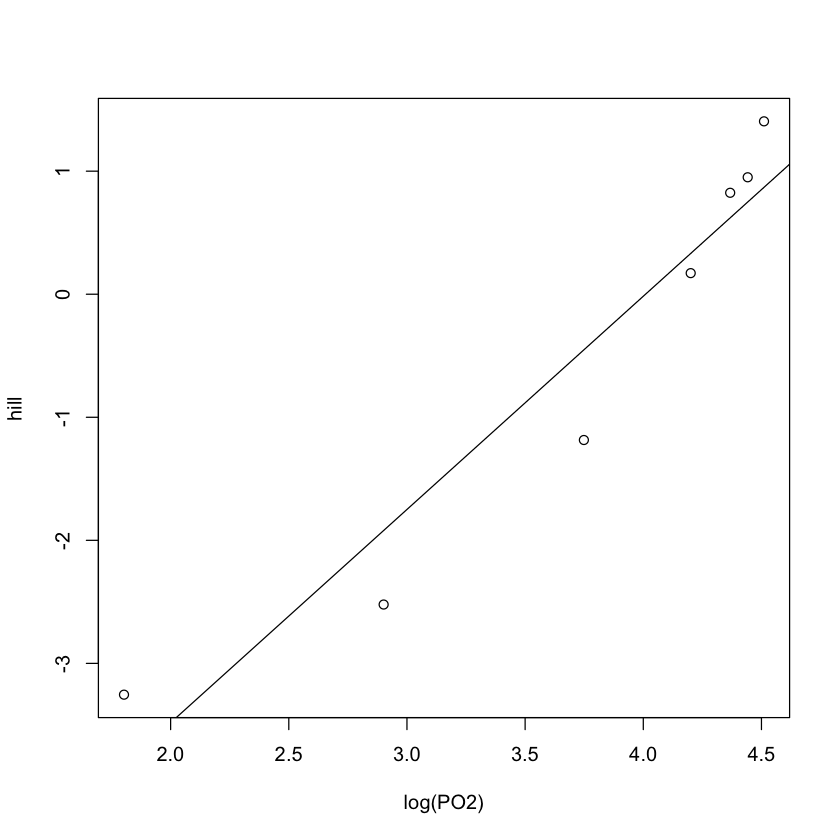

In [50]:
summary(lm(hill~log(PO2), data=hem_73))
plot(hill~log(PO2), data=hem_73)
abline(a = -6.948, b = 1.733)


Call:
lm(formula = hill ~ log(PO2), data = hem_68)

Residuals:
       10        11        12        13        14        15 
-0.150785  0.246532 -0.064401 -0.008495  0.061694 -0.084545 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -7.47379    0.31255  -23.91 1.81e-05 ***
log(PO2)     1.51877    0.07968   19.06 4.46e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1571 on 4 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.9891,	Adjusted R-squared:  0.9864 
F-statistic: 363.3 on 1 and 4 DF,  p-value: 4.463e-05


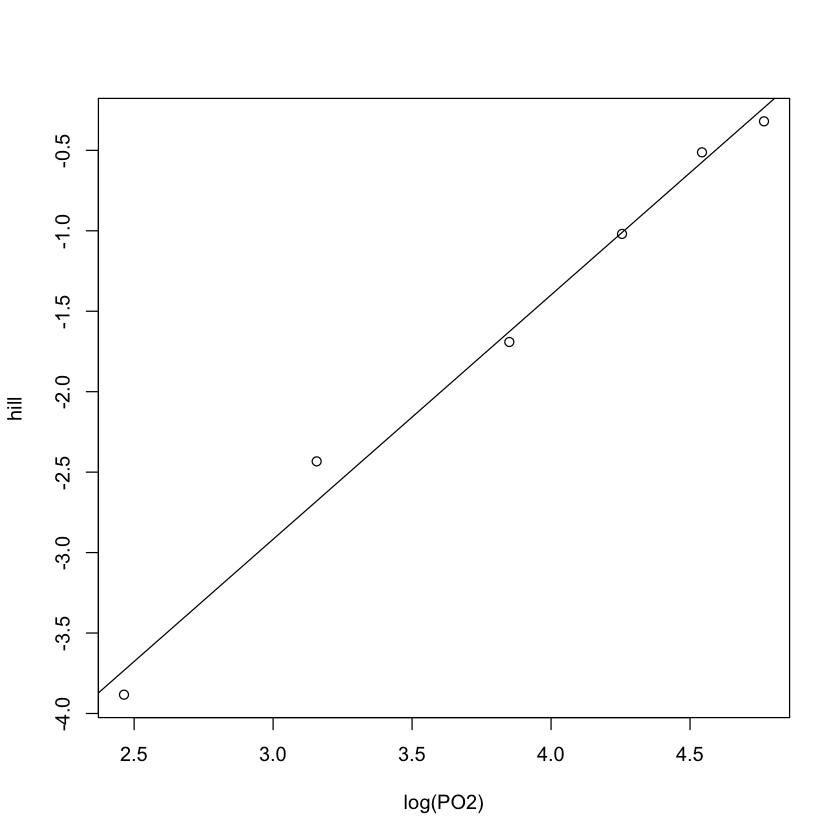

In [55]:
summary(lm(hill~log(PO2), data=hem_68))
plot(hill~log(PO2), data=hem_68)
abline(a = -7.47379, b = 1.51877)


Call:
lm(formula = hill ~ log(PO2), data = hem_78)

Residuals:
     17      18      19 
-0.1453  0.5275 -0.3822 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  -21.704      5.692  -3.813    0.163
log(PO2)       6.674      1.633   4.088    0.153

Residual standard error: 0.6675 on 1 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.9435,	Adjusted R-squared:  0.8871 
F-statistic: 16.71 on 1 and 1 DF,  p-value: 0.1527


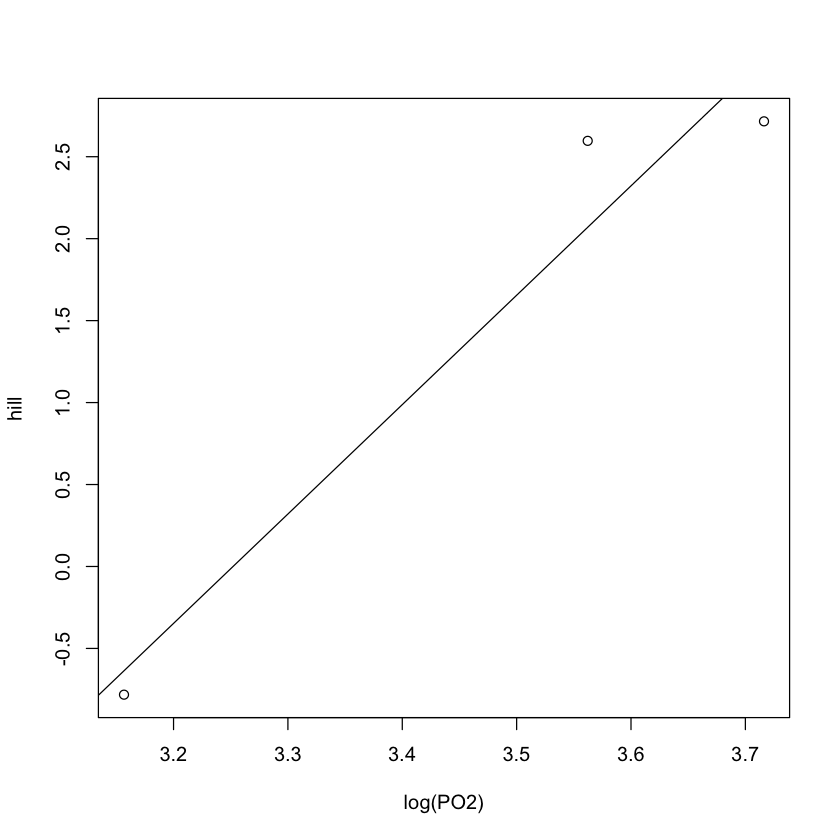

In [58]:
# This one is terrible
summary(lm(hill~log(PO2), data=hem_78))
plot(hill~log(PO2), data=hem_78)
abline(a = -21.704, b = 6.674)

3. Create a magnitude of Bohr Shift graph.


Call:
lm(formula = log(p50) ~ pH)

Residuals:
ALL 2 residuals are 0: no residual degrees of freedom!

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  4.24090         NA      NA       NA
pH          -0.01723         NA      NA       NA

Residual standard error: NaN on 0 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:    NaN 
F-statistic:   NaN on 1 and 0 DF,  p-value: NA


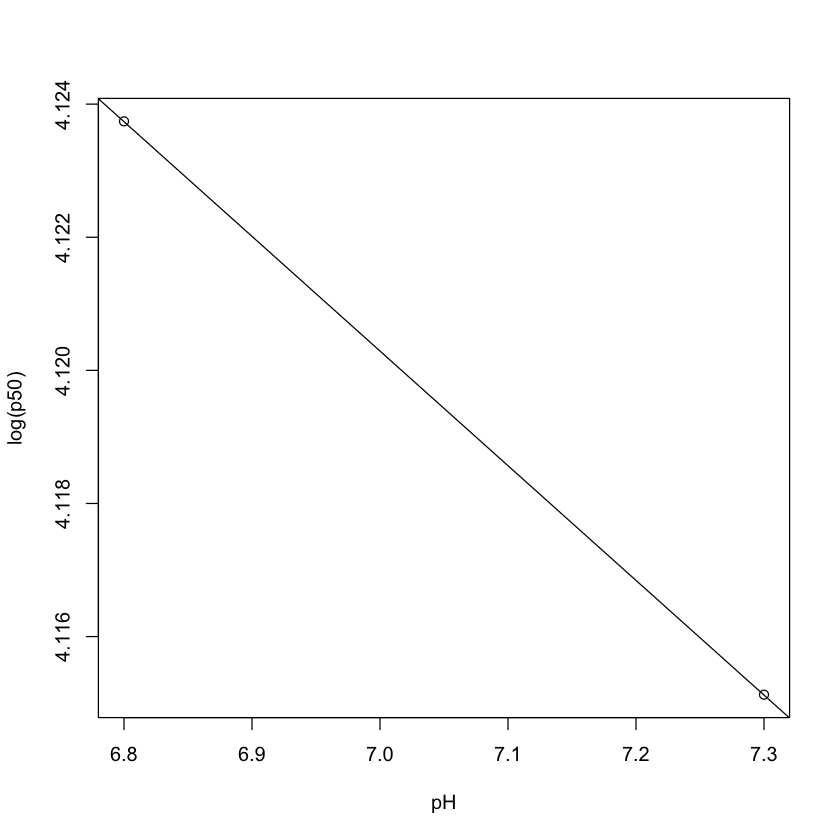

In [63]:
p50 = c(61.79, 61.26)
pH = c(6.8, 7.3)
summary(lm(log(p50)~pH))
plot(log(p50)~pH)
abline(a = 4.2409, b=-0.01723)